In [1]:
!pip install torch torchvision transformers diffusers datasets clip pillow accelerate

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"adityapsk","key":"2bab51d94d07b226191046d85261d86f"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d adityajn105/flickr8k

# Extract the dataset
!unzip flickr8k.zip -d flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/Images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/Images/2849194983_2968c72832.jpg  
  inflating: flickr8k/Images/2850719435_221f15e951.jpg  
  inflating: flickr8k/Images/28511987

In [20]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPTokenizer

# Define paths
image_dir = "flickr8k/Images"
caption_file = "flickr8k/captions.txt"

# Load the tokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Custom dataset class for Flickr8k
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, caption_file, tokenizer, transform=None):
        self.image_dir = image_dir
        self.captions = self.load_captions(caption_file)
        self.tokenizer = tokenizer
        self.transform = transform

    def load_captions(self, caption_file):
        with open(caption_file, 'r') as f:
            lines = f.readlines()
        captions = {}
        for line in lines[1:]:
            parts = line.strip().split(',')
            image_id = parts[0]
            caption = ','.join(parts[1:])
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(caption)
        return captions

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image_id = list(self.captions.keys())[idx]
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        caption = self.captions[image_id][0]  # Use the first caption for simplicity
        tokens = self.tokenizer(caption, return_tensors="pt", padding="max_length", truncation=True).input_ids
        return image, tokens.squeeze()

# Create dataset and dataloader
flickr_dataset = Flickr8kDataset(image_dir=image_dir, caption_file=caption_file, tokenizer=tokenizer, transform=transform)
data_loader = DataLoader(flickr_dataset, batch_size=2, shuffle=True)

In [21]:
import torch
from diffusers import StableDiffusionPipeline, PNDMScheduler, AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer

# Define parameters
model_id = "CompVis/stable-diffusion-v1-4"
num_images = 5

# Load the VAE
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.float16).to("cuda")

# Load the tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=torch.float16).to("cuda")

# Load the UNet model
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=torch.float16).to("cuda")

# Load the scheduler
scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Create the pipeline with explicit components
pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    safety_checker=None,
    feature_extractor=None
).to("cuda")

# Generate an image from a prompt
prompt = "A futuristic cityscape at sunset"

# Generate images
with torch.no_grad():
    generated_images = pipeline(prompt, num_inference_steps=50, guidance_scale=7.5, num_images_per_prompt=num_images).images

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

[PROMPT]:  A futuristic cityscape at sunset


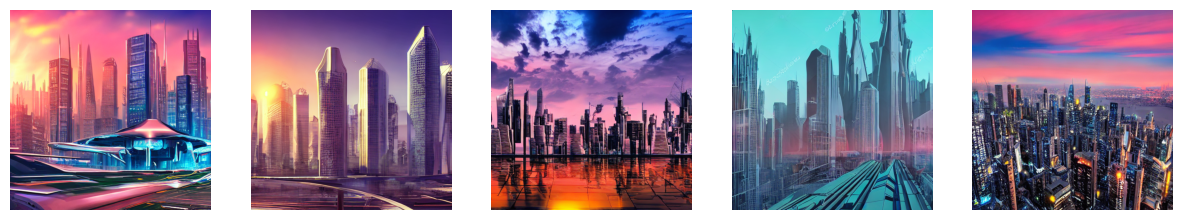

In [22]:
print("[PROMPT]: ",prompt)

import matplotlib.pyplot as plt

# Assuming 'images' is a list or array of PIL images
num_images = 5  # Number of images to display

# Create a figure with a grid of subplots (1 row and 5 columns)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Loop through the images and display each one in a subplot
for i in range(num_images):
    axes[i].imshow(generated_images[i])
    axes[i].axis('off')  # Hide the axes

# Display the grid of images
plt.show()

### Fine Tuning

In [23]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Optimizer and criterion
optimizer = torch.optim.AdamW(list(unet.parameters()) + list(text_encoder.parameters()), lr=1e-5)
criterion = torch.nn.MSELoss()

# Set model to training mode
unet.train()
text_encoder.train()

num_epochs = 1  # Increase as needed
max_grad_norm = 1.0

In [24]:
for epoch in range(num_epochs):
    for step, (images, captions) in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()

        # Move data to GPU
        images = images.to("cuda").half()
        captions = captions.to("cuda")

        # Forward pass
        latents = vae.encode(images).latent_dist.sample().detach()
        latents = latents * vae.config.scaling_factor

        noise = torch.randn_like(latents).to("cuda")
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (images.shape[0],), device=images.device).long()

        # Get noisy latent images
        noisy_latents = scheduler.add_noise(latents, noise, timesteps)

        # Get the model's predicted noise
        text_embeddings = text_encoder(captions).last_hidden_state
        noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample

        # Calculate loss
        loss = criterion(noise_pred, noise)

        # Handle NaNs and Infs
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN or Inf detected at step {step}. Skipping this step.")
            continue

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_grad_norm)

        # Step optimizer
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} completed. Loss: {loss.item()}")

# Save the fine-tuned models
unet.save_pretrained("fine_tuned_unet")
text_encoder.save_pretrained("fine_tuned_text_encoder")
vae.save_pretrained("fine_tuned_vae")
scheduler.save_pretrained("fine_tuned_scheduler")

  0%|          | 2/4046 [00:01<51:29,  1.31it/s]  

NaN or Inf detected at step 1. Skipping this step.


  0%|          | 3/4046 [00:02<39:46,  1.69it/s]

NaN or Inf detected at step 2. Skipping this step.


  0%|          | 4/4046 [00:02<33:54,  1.99it/s]

NaN or Inf detected at step 3. Skipping this step.


  0%|          | 5/4046 [00:02<30:27,  2.21it/s]

NaN or Inf detected at step 4. Skipping this step.


  0%|          | 6/4046 [00:03<28:21,  2.37it/s]

NaN or Inf detected at step 5. Skipping this step.


  0%|          | 7/4046 [00:03<26:42,  2.52it/s]

NaN or Inf detected at step 6. Skipping this step.


  0%|          | 8/4046 [00:03<25:56,  2.59it/s]

NaN or Inf detected at step 7. Skipping this step.


  0%|          | 9/4046 [00:04<25:27,  2.64it/s]

NaN or Inf detected at step 8. Skipping this step.


  0%|          | 10/4046 [00:04<24:49,  2.71it/s]

NaN or Inf detected at step 9. Skipping this step.


  0%|          | 11/4046 [00:04<24:38,  2.73it/s]

NaN or Inf detected at step 10. Skipping this step.


  0%|          | 12/4046 [00:05<24:35,  2.73it/s]

NaN or Inf detected at step 11. Skipping this step.


  0%|          | 13/4046 [00:05<24:12,  2.78it/s]

NaN or Inf detected at step 12. Skipping this step.


  0%|          | 14/4046 [00:05<24:13,  2.77it/s]

NaN or Inf detected at step 13. Skipping this step.


  0%|          | 15/4046 [00:06<24:45,  2.71it/s]

NaN or Inf detected at step 14. Skipping this step.


  0%|          | 16/4046 [00:06<25:04,  2.68it/s]

NaN or Inf detected at step 15. Skipping this step.


  0%|          | 17/4046 [00:07<25:21,  2.65it/s]

NaN or Inf detected at step 16. Skipping this step.


  0%|          | 18/4046 [00:07<25:26,  2.64it/s]

NaN or Inf detected at step 17. Skipping this step.


  0%|          | 19/4046 [00:07<25:34,  2.62it/s]

NaN or Inf detected at step 18. Skipping this step.


  0%|          | 20/4046 [00:08<25:07,  2.67it/s]

NaN or Inf detected at step 19. Skipping this step.


  1%|          | 21/4046 [00:08<25:21,  2.65it/s]

NaN or Inf detected at step 20. Skipping this step.


  1%|          | 22/4046 [00:09<25:39,  2.61it/s]

NaN or Inf detected at step 21. Skipping this step.


  1%|          | 23/4046 [00:09<25:34,  2.62it/s]

NaN or Inf detected at step 22. Skipping this step.


  1%|          | 24/4046 [00:09<25:13,  2.66it/s]

NaN or Inf detected at step 23. Skipping this step.


  1%|          | 25/4046 [00:10<25:47,  2.60it/s]

NaN or Inf detected at step 24. Skipping this step.


  1%|          | 26/4046 [00:10<26:25,  2.54it/s]

NaN or Inf detected at step 25. Skipping this step.


  1%|          | 27/4046 [00:10<25:34,  2.62it/s]

NaN or Inf detected at step 26. Skipping this step.


  1%|          | 28/4046 [00:11<25:05,  2.67it/s]

NaN or Inf detected at step 27. Skipping this step.


  1%|          | 29/4046 [00:11<24:38,  2.72it/s]

NaN or Inf detected at step 28. Skipping this step.


  1%|          | 30/4046 [00:12<24:17,  2.76it/s]

NaN or Inf detected at step 29. Skipping this step.


  1%|          | 31/4046 [00:12<24:07,  2.77it/s]

NaN or Inf detected at step 30. Skipping this step.


  1%|          | 32/4046 [00:12<24:03,  2.78it/s]

NaN or Inf detected at step 31. Skipping this step.


  1%|          | 33/4046 [00:13<23:59,  2.79it/s]

NaN or Inf detected at step 32. Skipping this step.


  1%|          | 34/4046 [00:13<24:06,  2.77it/s]

NaN or Inf detected at step 33. Skipping this step.


  1%|          | 35/4046 [00:13<24:11,  2.76it/s]

NaN or Inf detected at step 34. Skipping this step.


  1%|          | 36/4046 [00:14<24:12,  2.76it/s]

NaN or Inf detected at step 35. Skipping this step.


  1%|          | 37/4046 [00:14<24:25,  2.74it/s]

NaN or Inf detected at step 36. Skipping this step.


  1%|          | 38/4046 [00:14<24:20,  2.74it/s]

NaN or Inf detected at step 37. Skipping this step.


  1%|          | 39/4046 [00:15<24:21,  2.74it/s]

NaN or Inf detected at step 38. Skipping this step.


  1%|          | 40/4046 [00:15<24:22,  2.74it/s]

NaN or Inf detected at step 39. Skipping this step.


  1%|          | 41/4046 [00:16<24:23,  2.74it/s]

NaN or Inf detected at step 40. Skipping this step.


  1%|          | 42/4046 [00:16<24:16,  2.75it/s]

NaN or Inf detected at step 41. Skipping this step.


  1%|          | 43/4046 [00:16<24:23,  2.74it/s]

NaN or Inf detected at step 42. Skipping this step.


  1%|          | 44/4046 [00:17<24:18,  2.74it/s]

NaN or Inf detected at step 43. Skipping this step.


  1%|          | 45/4046 [00:17<24:03,  2.77it/s]

NaN or Inf detected at step 44. Skipping this step.


  1%|          | 46/4046 [00:17<24:00,  2.78it/s]

NaN or Inf detected at step 45. Skipping this step.


  1%|          | 47/4046 [00:18<23:47,  2.80it/s]

NaN or Inf detected at step 46. Skipping this step.


  1%|          | 47/4046 [00:18<26:16,  2.54it/s]


KeyboardInterrupt: 

In [ ]:
from diffusers import StableDiffusionPipeline

torch.cuda.empty_cache()

# number of images to generate
num_images = 1
# Load the fine-tuned models explicitly
fine_tuned_unet = UNet2DConditionModel.from_pretrained("fine_tuned_unet")
fine_tuned_text_encoder = CLIPTextModel.from_pretrained("fine_tuned_text_encoder")
fine_tuned_vae = AutoencoderKL.from_pretrained("fine_tuned_vae")
fine_tuned_scheduler = PNDMScheduler.from_pretrained("fine_tuned_scheduler")

# Rebuild the pipeline with the fine-tuned components
fine_tuned_pipeline = StableDiffusionPipeline(
    vae=fine_tuned_vae,
    text_encoder=fine_tuned_text_encoder,
    tokenizer=tokenizer,  # Same tokenizer used earlier
    unet=fine_tuned_unet,
    scheduler=fine_tuned_scheduler,
    safety_checker=None,
    feature_extractor=None
).to("cuda")

# # Enable memory-efficient features
# fine_tuned_pipeline.enable_attention_slicing()
# fine_tuned_pipeline.enable_vae_tiling()

# Generate an image from a prompt using the fine-tuned model
prompt = "A futuristic cityscape at sunset"
# new_gen_images = fine_tuned_pipeline(prompt).images

# Generate images
with torch.no_grad():
    new_gen_images = fine_tuned_pipeline(prompt, num_inference_steps=50, guidance_scale=7.5, num_images_per_prompt=num_images).images

In [ ]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(new_gen_images[0])
plt.axis('off')  # Hide the axes
plt.show()